# Model Fitting II

### Addressing Endogeneity

To address the issue of endogeneity we need to find instruments for hours of studying that have the following characteristics:

* $\mathrm{Cov}[z, studying] \ne 0 \ \quad$ (hours of studying covaries with $z$)
* $\mathrm{Cov}[z, \varepsilon] = 0 \ \ \ \quad\quad\quad$ ($z$ is exogenous)

Looking at the variables in our dataset, `school_GP`, `goout`, and `male` are valid instruments we can use for our analysis. In addition, based off our two way frequency table (see Data Exploration) we found that 49 people stated they had picked the school because of its proximity to home and that they had a commute time greater than 15 minutes. This subset eliminates people that may have picked the school for reasons that may directly affect how much their test scores (e.g. Picking a school because of "Courses" might correlate with test scores) and only affects test scores indirectly through study time. Thus we can use this combination of variables as an artificial instrument.

Below we will use our instruments in a 2 stage least squares regression.


In [1]:
# Loading the libraries we will use and setting global options

# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

# Data manipulation and math/stats functions
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import quadratic2SLS as q2sls

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import self-made functions
from p3functions import *

In [2]:
#Load in cleaned data and resutls from our naive OLS fit
student_both = pd.read_pickle('data/student_por_v3.pkl')
student_por  = pd.read_pickle('data/student_por_v3.pkl')
student_mat  = pd.read_pickle('data/student_mat_v3.pkl')
#naive_ols = sm.load('results/Naive_OLS.pickle')

### 2SLS Model Fitting

*Note:* The write up explains why 2SLS might not be the best method for identifying $\beta$ in this setting. We include 2SLS results to compare the non standard Q2SLS results to a more familiar model.

In [73]:
# Running the 2SLS model

exog_names = ['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
               'reason_home', 'reason_course', 'reason_reputation',
               'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               'health_1', 'health_2', 'health_4', 'health_5']

# ----- Both Courses -----
# Dependent variable
Y = student_both.G3_perc

# Exogenous variables
X_exog = student_both[exog_names]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_both[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_both['artificial_instrument'] = ((student_both.reason == 'home') & (student_both.traveltime > 1)).astype(int)
Z = student_both[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_both = IV2SLS(Y, X_exog, X_endog, Z)
results2SLS_both = model2SLS_both.fit()


# ----- Portuguese Language Course -----
# Dependent variable
Y = student_por.G3_perc

# Exogenous variables
X_exog = student_por[exog_names]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_por[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z = student_por[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_por = IV2SLS(Y, X_exog, X_endog, Z)
results2SLS_por = model2SLS_por.fit()


# ----- Mathematics Course -----
# Dependent variable
Y = student_mat.G3_perc

# Exogenous variables
X_exog = student_mat[exog_names]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_mat[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_mat['artificial_instrument'] = ((student_mat.reason == 'home') & (student_mat.traveltime > 1)).astype(int)
Z = student_mat[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_mat = IV2SLS(Y, X_exog, X_endog, Z)
results2SLS_mat = model2SLS_mat.fit()

In [57]:
results2SLS_both.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -0.4135
Estimator:                    IV-2SLS   Adj. R-squared:                -0.5630
No. Observations:                 649   F-statistic:                    210.62
Date:                Thu, May 10 2018   P-value (F-stat)                0.0000
Time:                        16:30:54   Distribution:                 chi2(62)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.6430     0.2655     2.4215     0.0155      0.1226      1.1635
school_GP                   0.0323     0.0253     1.2785     0.2011     -0.0172      0.0819
male                        0.0199     0.0328     0.6069     0.5439     -0.0444      0.0842
age                        -0.0127     0.0134    -0.9481     0.3431     -0.0390      0.0136
urban                       0.0189     0.0206     0.9176     0.3588     -0.0215      0.0593
fam_small                   0.0274     0.0188     1.4614     0.1439     -0.0094      0.0642
fam_split                  -0.0333     0.0302    -1.1019     0.2705     -0.0925      0.0259
mother                     -0.0308     0.0441    -0.6987     0.4847     -0.1172      0.0556
father                     -0.0051     0.0417    -0.1211     0.9036     -0.0868      0.0767
failures                   -0.0628     0.0170    -3.6926     0.0002     -0.0961     -0.0295
school_sup                 -0.0784     0.0285    -2.7497     0.0060     -0.1343     -0.0225
famsup                     -0.0210     0.0194    -1.0858     0.2776     -0.0590      0.0169
paid                       -0.0091     0.0377    -0.2415     0.8092     -0.0830      0.0648
activities                 -0.0056     0.0197    -0.2818     0.7781     -0.0443      0.0331
nursery                    -0.0154     0.0206    -0.7481     0.4544     -0.0559      0.0250
higher                     -0.0027     0.0547    -0.0494     0.9606     -0.1099      0.1045
internet                    0.0119     0.0211     0.5634     0.5732     -0.0295      0.0533
romantic                   -0.0557     0.0300    -1.8565     0.0634     -0.1146      0.0031
absences                    0.0021     0.0028     0.7651     0.4442     -0.0033      0.0076
Mjob_teach                 -0.0032     0.0413    -0.0775     0.9382     -0.0841      0.0777
Mjob_health                 0.0546     0.0471     1.1598     0.2461     -0.0377      0.1468
Mjob_civil                  0.0267     0.0272     0.9792     0.3275     -0.0267      0.0801
Mjob_other                  0.0028     0.0211     0.1314     0.8955     -0.0385      0.0440
Fjob_teach                  0.0812     0.0579     1.4030     0.1606     -0.0322      0.1947
Fjob_health                -0.0170     0.0837    -0.2031     0.8391     -0.1810      0.1470
Fjob_civil                 -0.0005     0.0349    -0.0147     0.9883     -0.0689      0.0678
Fjob_other                  0.0371     0.0357     1.0406     0.2981     -0.0328      0.1070
Medu_primary               -0.0466     0.0603    -0.7724     0.4399     -0.1647      0.0716
Medu_5_9                   -0.0407     0.0646    -0.6306     0.5283     -0.1673      0.0859
Medu_secondary             -0.0360     0.0716    -0.5025     0.6153     -0.1762      0.1043
Medu_higher                -0.0194     0.0801    -0.2421     0.8087     -0.1765      0.1377
Fedu_primary   

In [52]:
results2SLS_por.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -0.4135
Estimator:                    IV-2SLS   Adj. R-squared:                -0.5630
No. Observations:                 649   F-statistic:                    210.62
Date:                Thu, May 10 2018   P-value (F-stat)                0.0000
Time:                        16:05:15   Distribution:                 chi2(62)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.6430     0.2655     2.4215     0.0155      0.1226      1.1635
school_GP                   0.0323     0.0253     1.2785     0.2011     -0.0172      0.0819
male                        0.0199     0.0328     0.6069     0.5439     -0.0444      0.0842
age                        -0.0127     0.0134    -0.9481     0.3431     -0.0390      0.0136
urban                       0.0189     0.0206     0.9176     0.3588     -0.0215      0.0593
fam_small                   0.0274     0.0188     1.4614     0.1439     -0.0094      0.0642
fam_split                  -0.0333     0.0302    -1.1019     0.2705     -0.0925      0.0259
mother                     -0.0308     0.0441    -0.6987     0.4847     -0.1172      0.0556
father                     -0.0051     0.0417    -0.1211     0.9036     -0.0868      0.0767
failures                   -0.0628     0.0170    -3.6926     0.0002     -0.0961     -0.0295
school_sup                 -0.0784     0.0285    -2.7497     0.0060     -0.1343     -0.0225
famsup                     -0.0210     0.0194    -1.0858     0.2776     -0.0590      0.0169
paid                       -0.0091     0.0377    -0.2415     0.8092     -0.0830      0.0648
activities                 -0.0056     0.0197    -0.2818     0.7781     -0.0443      0.0331
nursery                    -0.0154     0.0206    -0.7481     0.4544     -0.0559      0.0250
higher                     -0.0027     0.0547    -0.0494     0.9606     -0.1099      0.1045
internet                    0.0119     0.0211     0.5634     0.5732     -0.0295      0.0533
romantic                   -0.0557     0.0300    -1.8565     0.0634     -0.1146      0.0031
absences                    0.0021     0.0028     0.7651     0.4442     -0.0033      0.0076
Mjob_teach                 -0.0032     0.0413    -0.0775     0.9382     -0.0841      0.0777
Mjob_health                 0.0546     0.0471     1.1598     0.2461     -0.0377      0.1468
Mjob_civil                  0.0267     0.0272     0.9792     0.3275     -0.0267      0.0801
Mjob_other                  0.0028     0.0211     0.1314     0.8955     -0.0385      0.0440
Fjob_teach                  0.0812     0.0579     1.4030     0.1606     -0.0322      0.1947
Fjob_health                -0.0170     0.0837    -0.2031     0.8391     -0.1810      0.1470
Fjob_civil                 -0.0005     0.0349    -0.0147     0.9883     -0.0689      0.0678
Fjob_other                  0.0371     0.0357     1.0406     0.2981     -0.0328      0.1070
Medu_primary               -0.0466     0.0603    -0.7724     0.4399     -0.1647      0.0716
Medu_5_9                   -0.0407     0.0646    -0.6306     0.5283     -0.1673      0.0859
Medu_secondary             -0.0360     0.0716    -0.5025     0.6153     -0.1762      0.1043
Medu_higher                -0.0194     0.0801    -0.2421     0.8087     -0.1765      0.1377
Fedu_primary   

In [53]:
results2SLS_mat.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -0.2619
Estimator:                    IV-2SLS   Adj. R-squared:                -0.4975
No. Observations:                 395   F-statistic:                    193.92
Date:                Thu, May 10 2018   P-value (F-stat)                0.0000
Time:                        16:05:15   Distribution:                 chi2(62)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       1.1744     0.4031     2.9134     0.0036      0.3843      1.9644
school_GP                   0.0024     0.0640     0.0380     0.9697     -0.1230      0.1278
male                        0.1355     0.0666     2.0350     0.0418      0.0050      0.2661
age                        -0.0321     0.0175    -1.8372     0.0662     -0.0663      0.0021
urban                       0.0069     0.0577     0.1205     0.9041     -0.1061      0.1200
fam_small                   0.0821     0.0407     2.0158     0.0438      0.0023      0.1619
fam_split                  -0.0286     0.0525    -0.5457     0.5853     -0.1315      0.0742
mother                     -0.0365     0.0624    -0.5845     0.5589     -0.1588      0.0859
father                      0.0191     0.0768     0.2481     0.8040     -0.1315      0.1696
failures                   -0.0894     0.0310    -2.8864     0.0039     -0.1501     -0.0287
school_sup                 -0.0486     0.0413    -1.1767     0.2393     -0.1296      0.0324
famsup                     -0.0471     0.0329    -1.4337     0.1516     -0.1115      0.0173
paid                        0.0110     0.0354     0.3107     0.7561     -0.0585      0.0805
activities                 -0.0533     0.0403    -1.3223     0.1861     -0.1322      0.0257
nursery                    -0.0067     0.0423    -0.1578     0.8746     -0.0896      0.0762
higher                      0.0027     0.0945     0.0281     0.9776     -0.1826      0.1879
internet                    0.0192     0.0520     0.3689     0.7122     -0.0827      0.1211
romantic                   -0.1253     0.0550    -2.2781     0.0227     -0.2331     -0.0175
absences                    0.0036     0.0026     1.3833     0.1666     -0.0015      0.0087
Mjob_teach                 -0.1023     0.0869    -1.1773     0.2391     -0.2727      0.0680
Mjob_health                 0.0192     0.1076     0.1784     0.8584     -0.1918      0.2302
Mjob_civil                  0.0314     0.0714     0.4402     0.6598     -0.1085      0.1713
Mjob_other                 -0.0056     0.0540    -0.1030     0.9180     -0.1114      0.1003
Fjob_teach                  0.1130     0.0999     1.1316     0.2578     -0.0828      0.3088
Fjob_health                 0.0980     0.1481     0.6616     0.5082     -0.1923      0.3883
Fjob_civil                  0.0704     0.0932     0.7556     0.4499     -0.1122      0.2530
Fjob_other                  0.0502     0.0789     0.6362     0.5246     -0.1045      0.2049
Medu_primary               -0.2556     0.1238    -2.0645     0.0390     -0.4983     -0.0129
Medu_5_9                   -0.1995     0.1221    -1.6331     0.1024     -0.4389      0.0399
Medu_secondary             -0.1800     0.1267    -1.4209     0.1553     -0.4283      0.0683
Medu_higher                -0.0971     0.1417    -0.6855     0.4930     -0.3748      0.1806
Fedu_primary   

In [54]:
#### JUST CHECKING VARIOUS PARAMETERS, DELETE THIS CHUNK LATER
results2SLS_both.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 2.7210
P-value: 0.4367
Distributed: chi2(3)
WaldTestStatistic, id: 0x1c2705ea58

### Q2SLS Model Fitting

# NEED TO FIGURE OUT BOOTSTRAPPING FOR ERRORS
--> and change n_iter to something reasonable, now its low for runtime

In [14]:
# Running the Q2SLS model

exog_names = ['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
               'reason_home', 'reason_course', 'reason_reputation',
               'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               'health_1', 'health_2', 'health_4', 'health_5']

# ----- Both Courses -----
# Dependent variable
Y1 = student_both.G3_perc

# Exogenous variables
X_exog1 = student_both[exog_names]
X_exog1 = sm.add_constant(X_exog1)

# Endogenous variable
X_endog1 = student_both.studytime_continuous

# Instruments
student_both['artificial_instrument'] = ((student_both.reason == 'home') & (student_both.traveltime > 1)).astype(int)
Z1 = student_both[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_both = q2sls.Quadratic2SLS(Y1, X_exog1, X_endog1, Z1)
resultsQ2SLS_both = modelQ2SLS_both.fit(cov_type='Bootstrap', n_iter=100)


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por.studytime_continuous

# Instruments
student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z2 = student_por[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_por = q2sls.Quadratic2SLS(Y2, X_exog2, X_endog2, Z2)
resultsQ2SLS_por = modelQ2SLS_por.fit(cov_type='Bootstrap', n_iter=100)


# ----- Mathematics Course -----
# Dependent variable
Y = student_mat.G3_perc

# Exogenous variables
X_exog = student_mat[exog_names]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_mat.studytime_continuous

# Instruments
student_mat['artificial_instrument'] = ((student_mat.reason == 'home') & (student_mat.traveltime > 1)).astype(int)
Z = student_mat[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_mat = q2sls.Quadratic2SLS(Y, X_exog, X_endog, Z)
resultsQ2SLS_mat = modelQ2SLS_mat.fit(cov_type='Bootstrap', n_iter=100)

100%|██████████| 100/100 [00:01<00:00, 54.90it/s]


In [15]:
coeff_estms_Q2SLS_both = pd.DataFrame([resultsQ2SLS_both.beta_hat_boots.mean(axis=0), resultsQ2SLS_both.result2.params]).transpose()
coeff_estms_Q2SLS_both.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms_Q2SLS_both.head()

,Bootstrapped,Full_Sample
const,0.372352,0.358818
endog_hat,0.022625,0.032979
endog_sq_hat,0.000066,0.000027
school_GP,0.049876,0.045755
male,-0.021186,-0.014037


# ISSUE: portugal results are different in the below chunk and the chunk below that. need to figure out why

In [16]:
#import quadratic2SLS as q2sls
#import importlib
#importlib.reload(q2sls)

Y = student_por.G3_perc
X = student_por[['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
X_endog = student_por['studytime_continuous']
student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z = student_por[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model = q2sls.Quadratic2SLS(Y, X, X_endog, Z)
result_20000 = model.fit(cov_type='Bootstrap', n_iter=1000)
coeff_estms_20000 = pd.DataFrame([result_20000.beta_hat_boots.mean(axis=0), result_20000.result2.params]).transpose()
coeff_estms_20000.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms_20000.head()

100%|██████████| 1000/1000 [00:17<00:00, 57.72it/s]


,Bootstrapped,Full_Sample
const,0.399672,0.406712
endog_hat,0.018762,0.033041
endog_sq_hat,-0.000016,-0.000466
school_GP,0.052294,0.045912
male,-0.024489,-0.017643


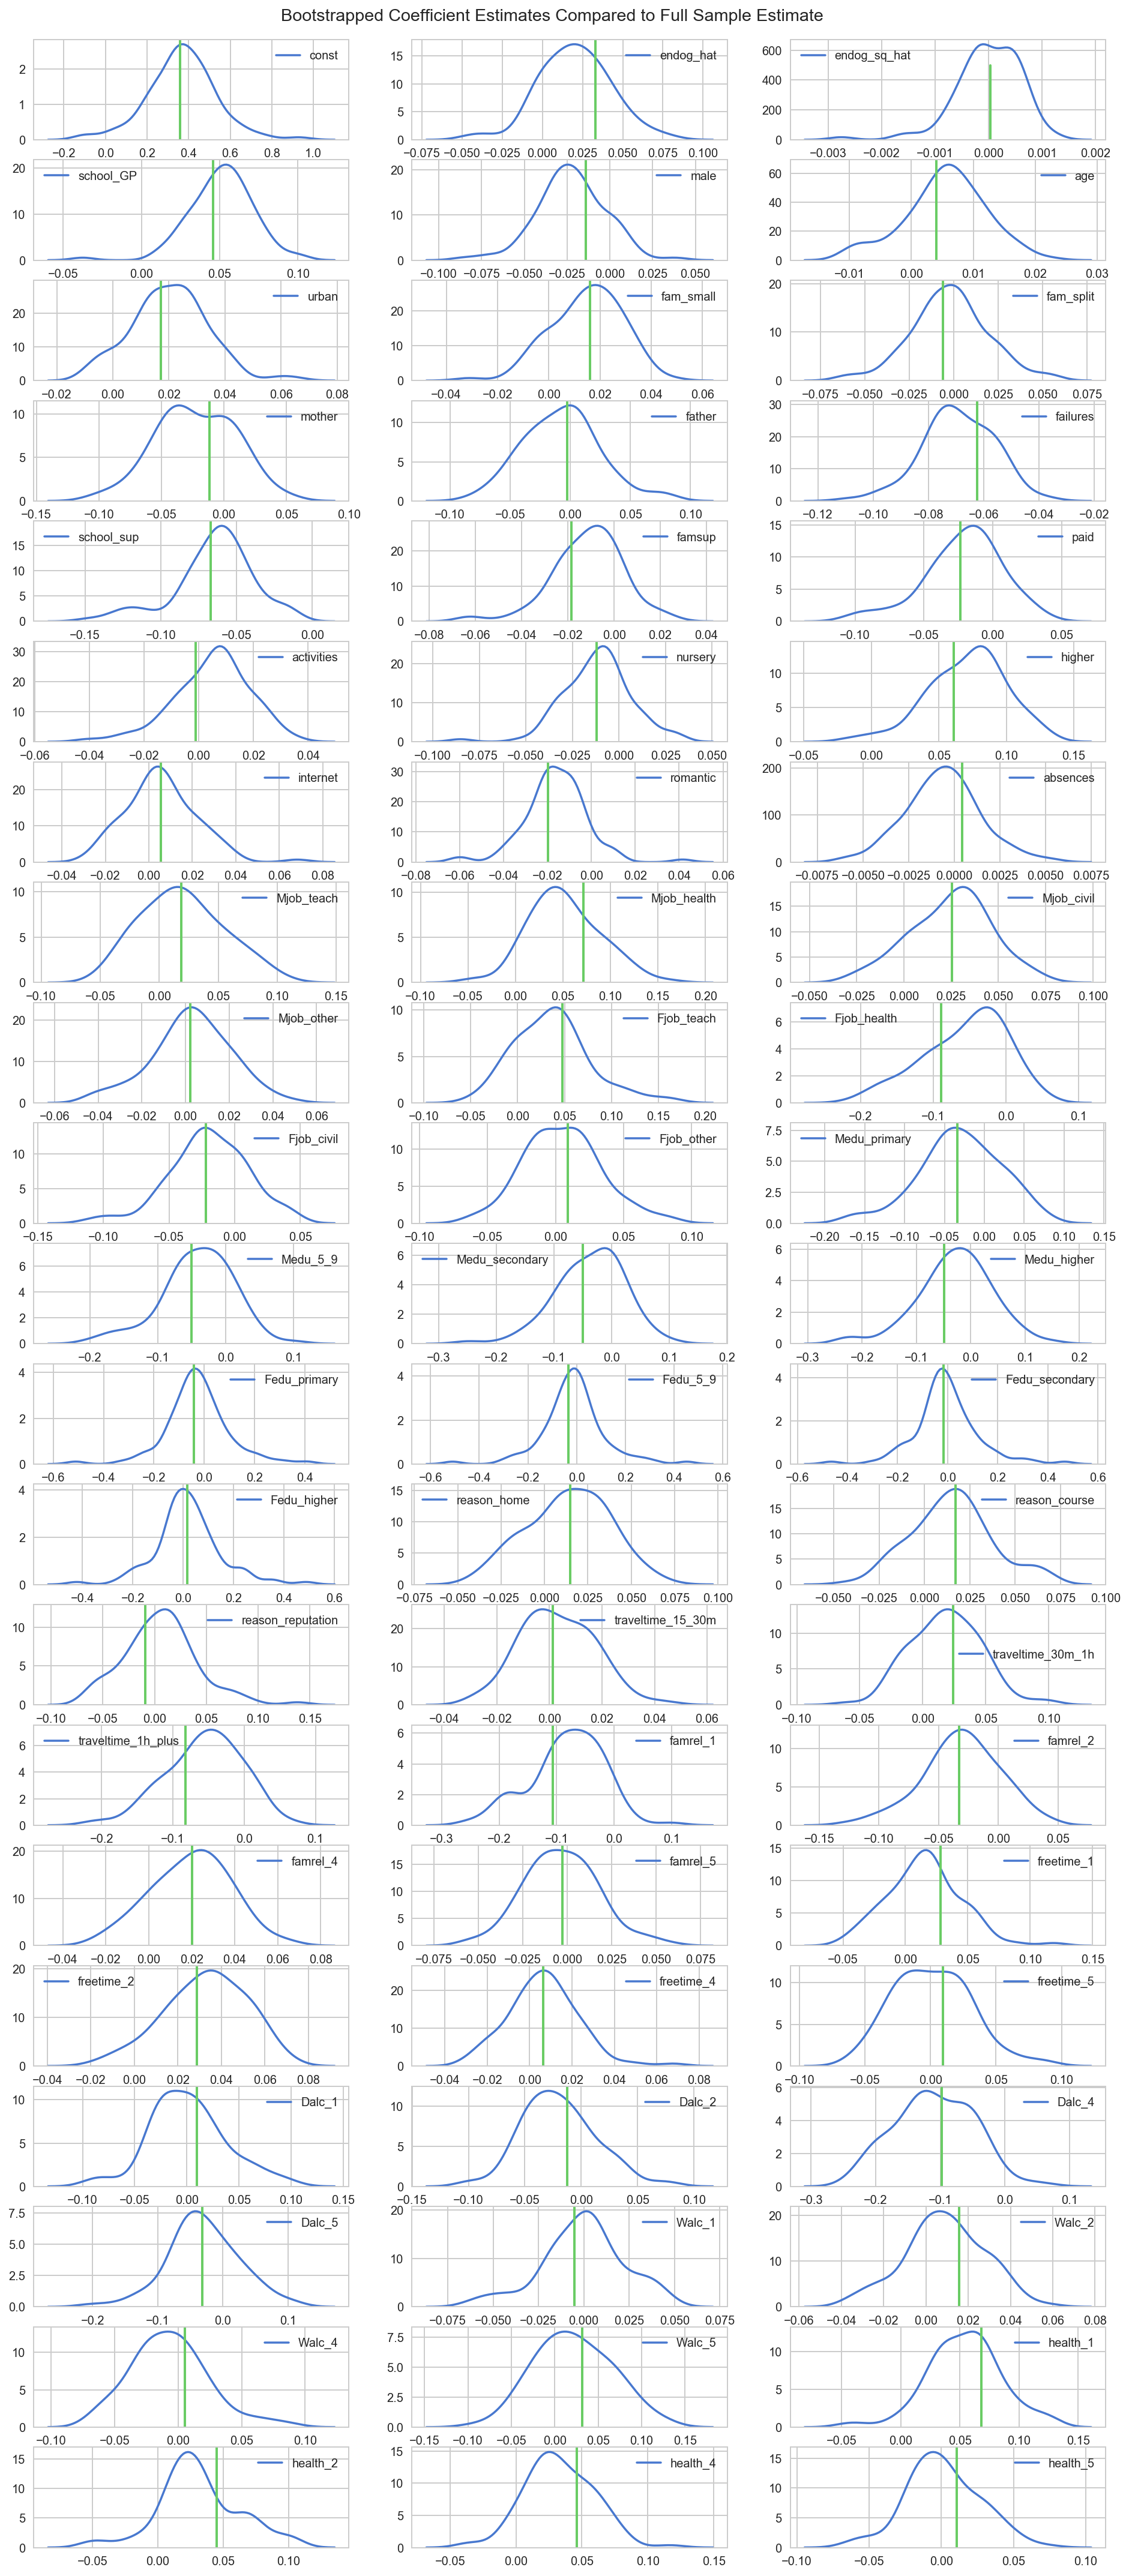

In [96]:
# Creating the plots
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs. Full Sample Estimate - Both Courses')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_both.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_both.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_both.result2.params[column_index], resultsQ2SLS_both.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)

In [11]:
coeff_estms_Q2SLS_por = pd.DataFrame([resultsQ2SLS_por.beta_hat_boots.mean(axis=0), resultsQ2SLS_por.result2.params]).transpose()
coeff_estms_Q2SLS_por.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms_Q2SLS_por.head()

,Bootstrapped,Full_Sample
const,0.346939,0.358818
endog_hat,0.018580,0.032979
endog_sq_hat,0.000061,0.000027
school_GP,0.051523,0.045755
male,-0.024196,-0.014037


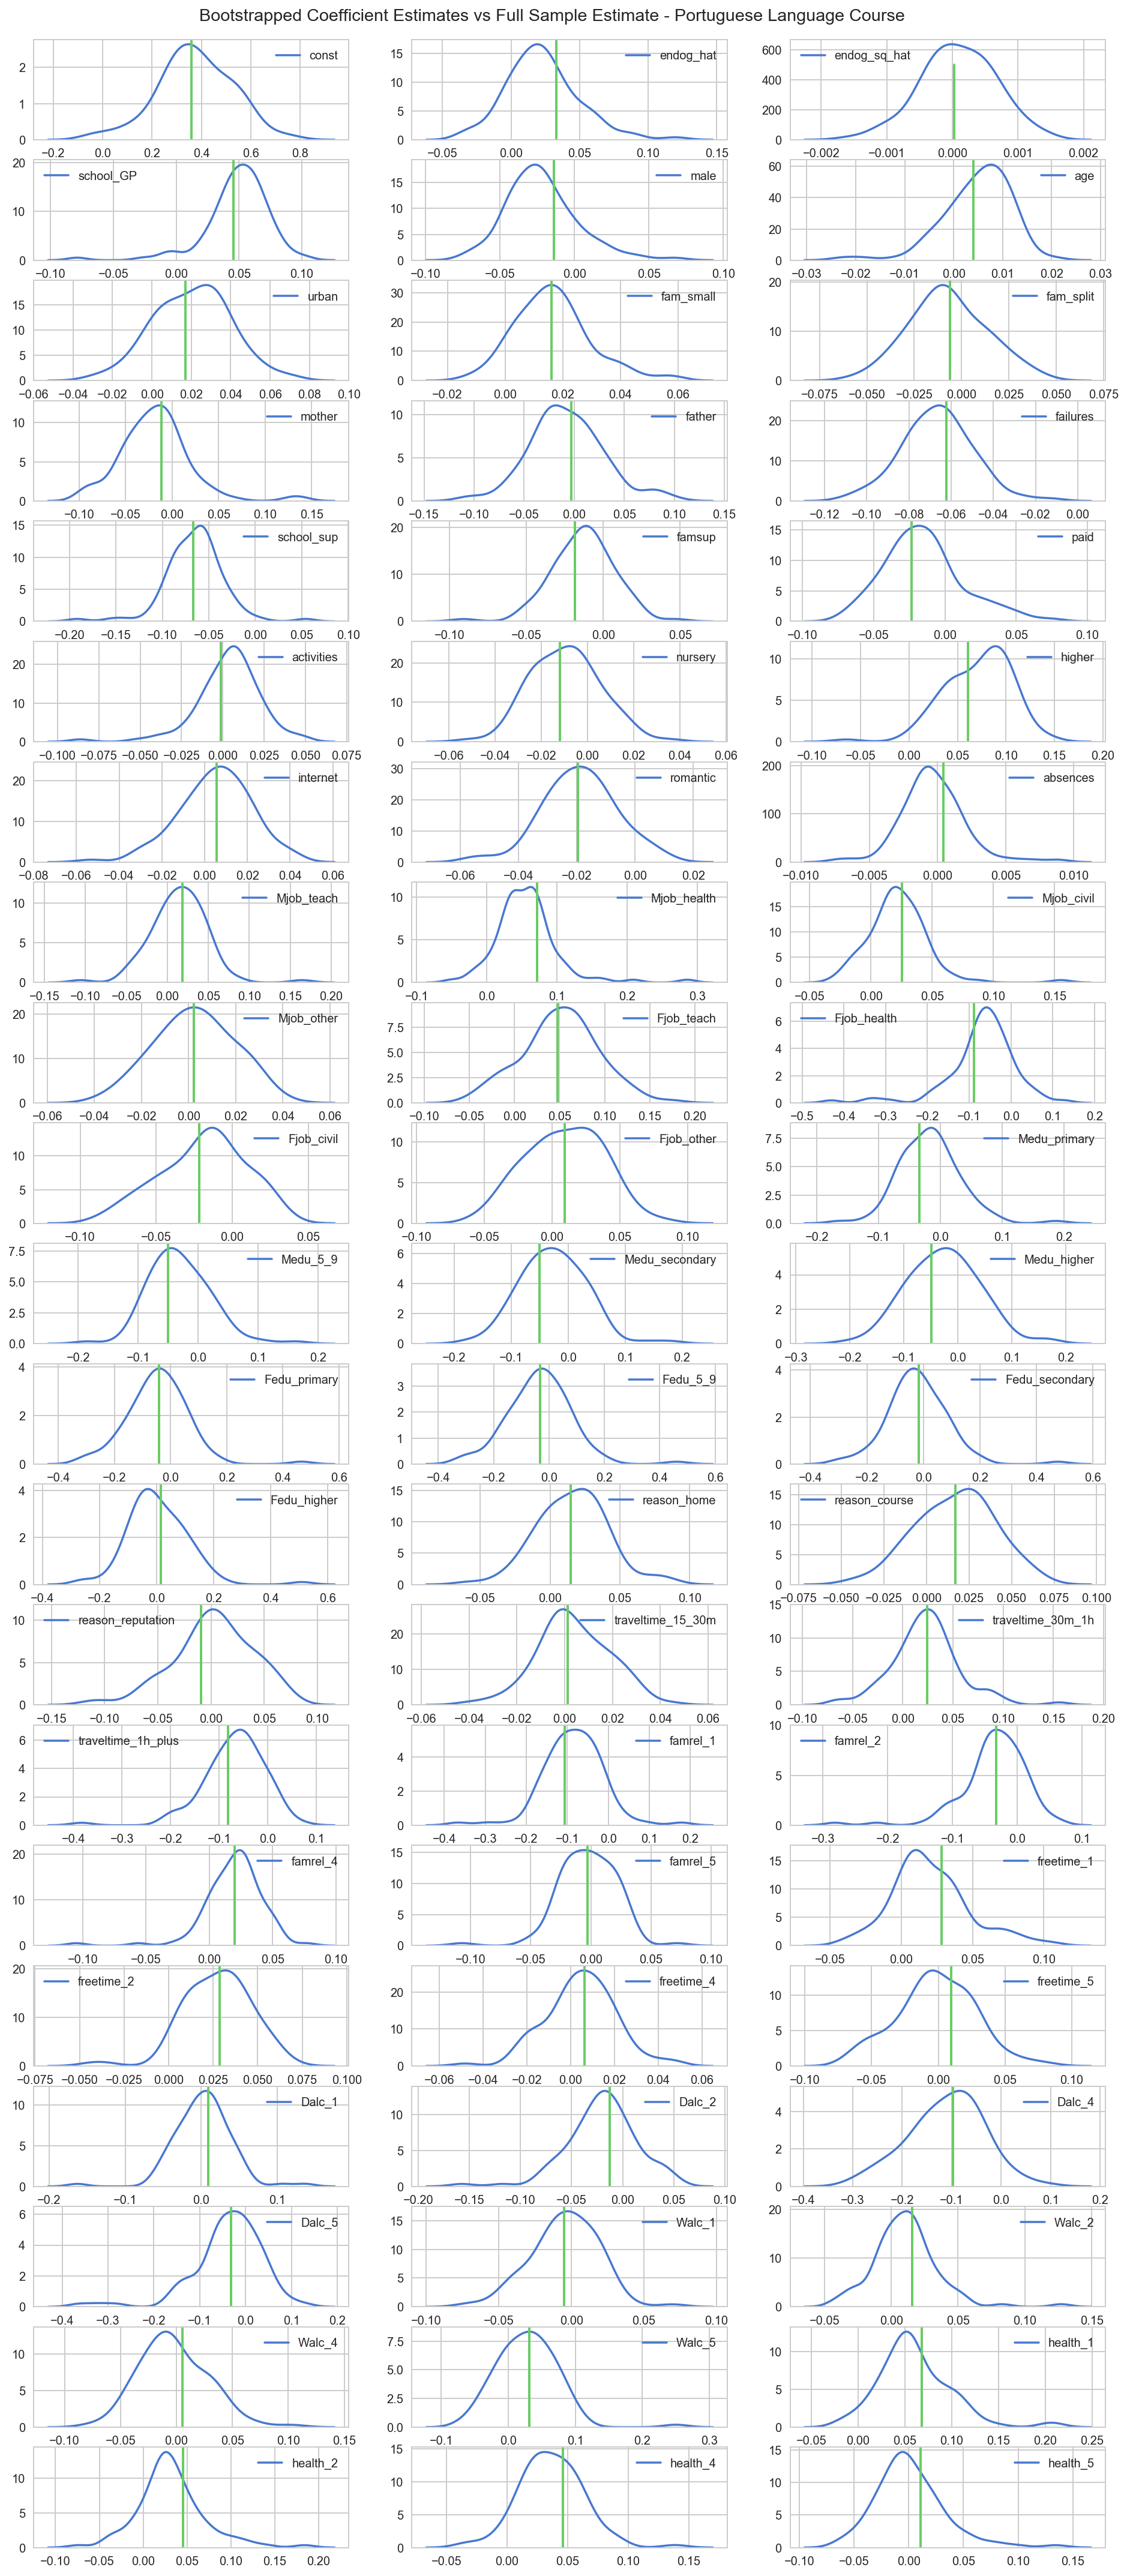

In [100]:
# Creating the plots
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Portuguese Language Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_por.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_por.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_por.result2.params[column_index], resultsQ2SLS_por.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)

In [6]:
coeff_estms_Q2SLS_mat = pd.DataFrame([resultsQ2SLS_mat.beta_hat_boots.mean(axis=0), resultsQ2SLS_mat.result2.params]).transpose()
coeff_estms_Q2SLS_mat.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms_Q2SLS_mat.head()

,Bootstrapped,Full_Sample
const,1.227837,1.144501
endog_hat,0.011931,0.014422
endog_sq_hat,0.000184,0.000555
school_GP,-0.055128,-0.052295
male,0.073409,0.079927


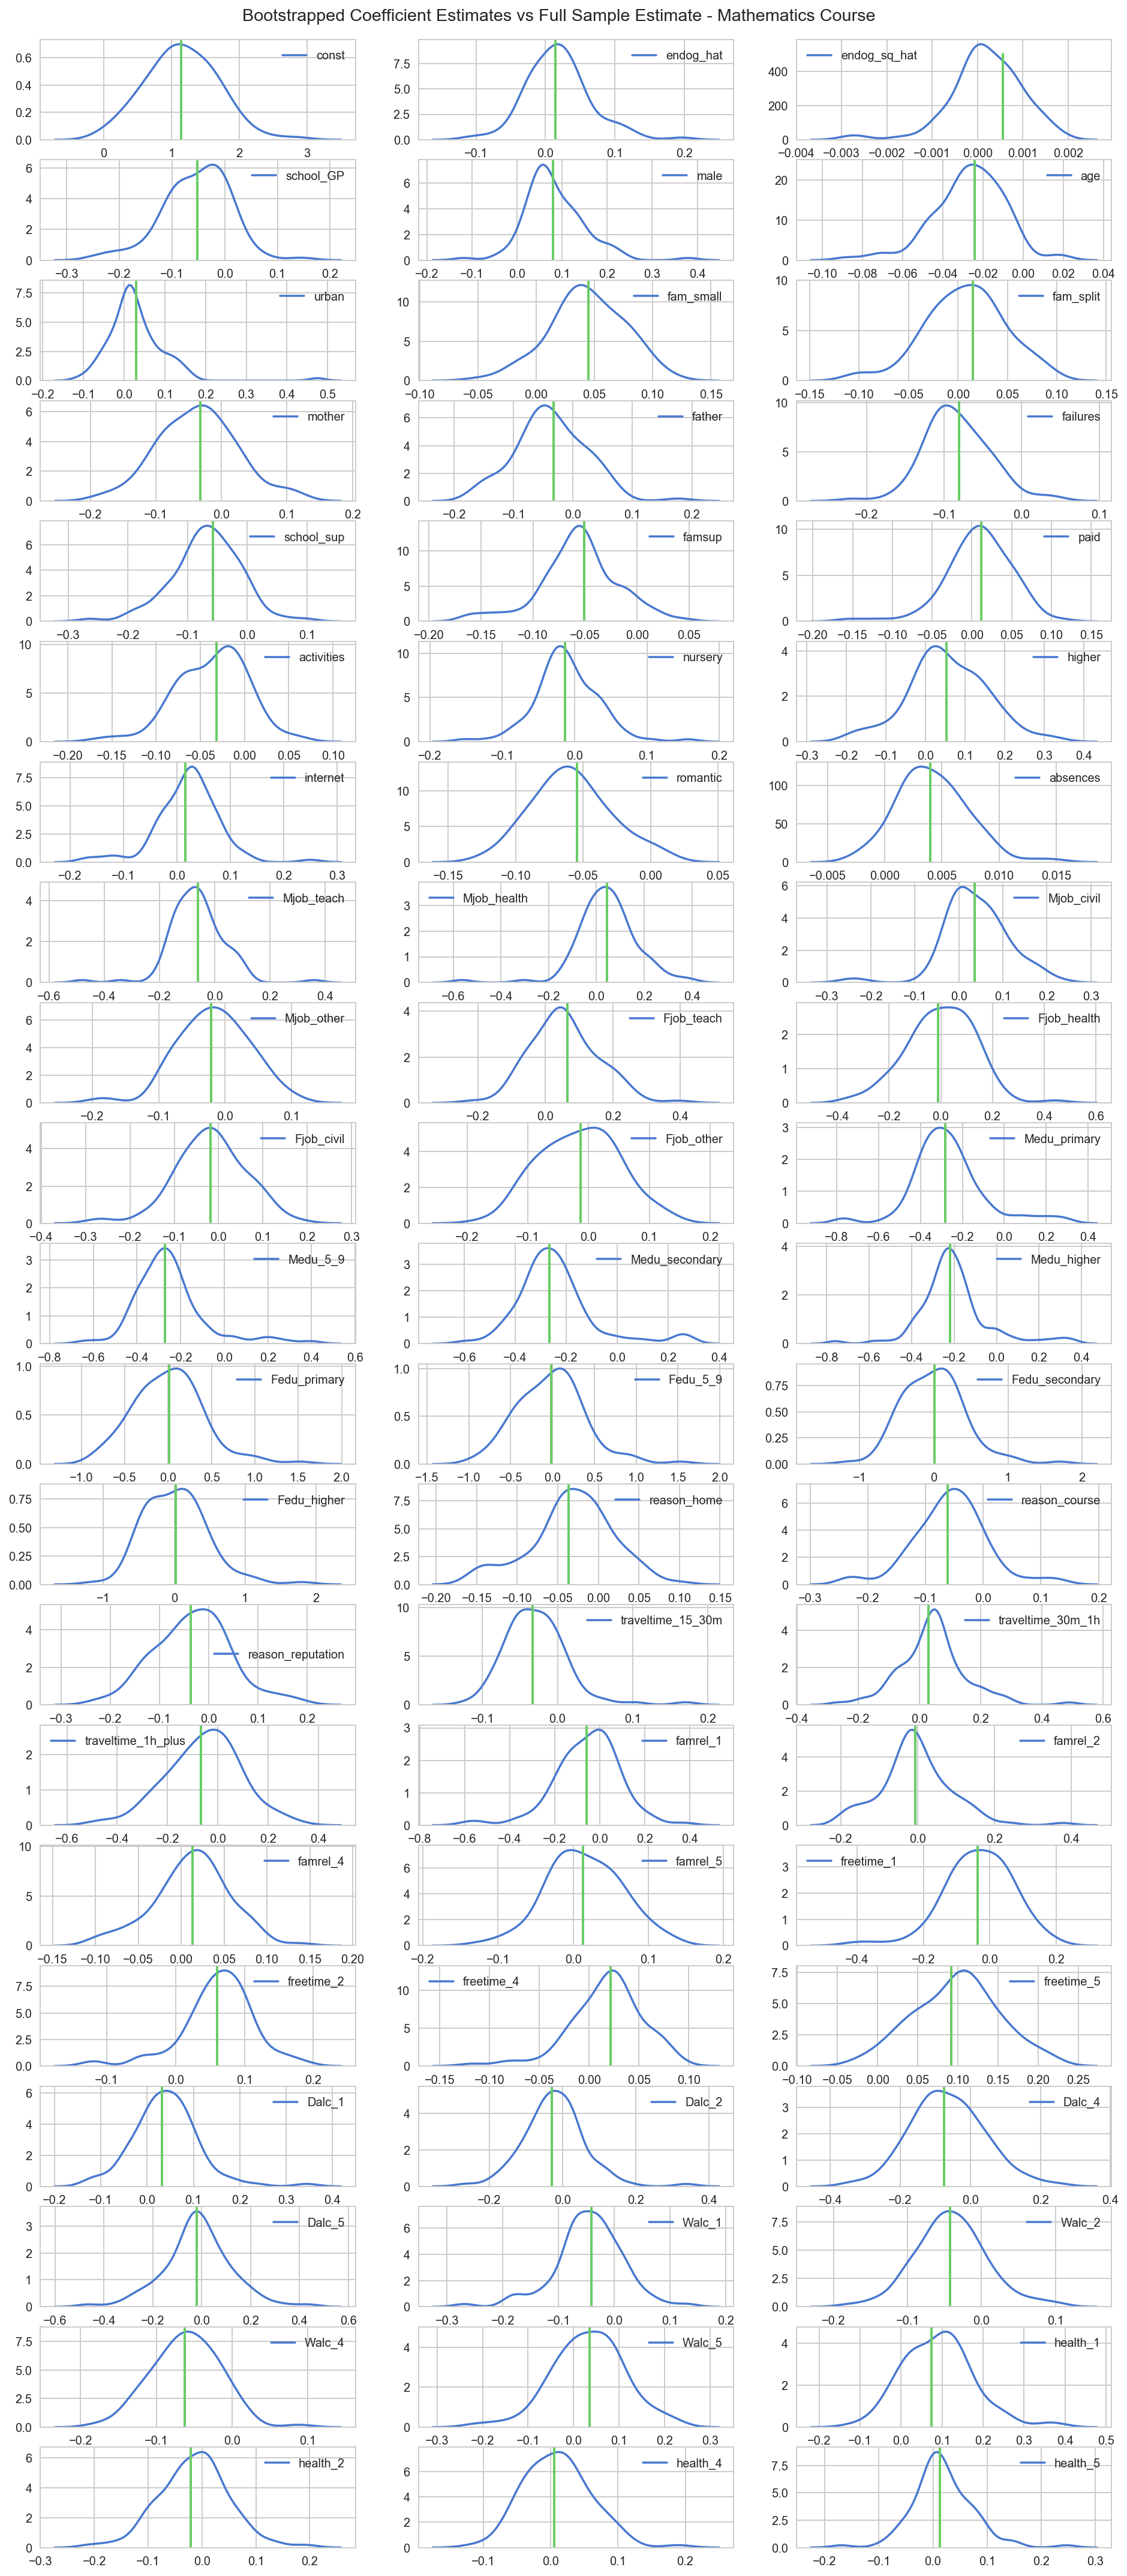

In [97]:
# Creating the plots
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Mathematics Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_mat.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_mat.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_mat.result2.params[column_index], resultsQ2SLS_mat.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)

# BELOW HERE IS OLD

In [4]:
np.mean(naive_ols.pvalues)

0.22334223263062752

In [5]:
np.mean(results.pvalues)

0.4006033698492225

Comparing the average p values of the 2 models, its evident that our average coefficient significance has fallen from OLS to 2SLS which we expected. Let's take a look at which coefficients have become more significant in the 2SLS model.

In [6]:
naive_ols.pvalues - results.pvalues

Dalc          0.051493
Fedu          0.040040
Medu         -0.381039
Walc         -0.167344
absences     -0.702835
activities   -0.595928
age          -0.856471
const        -0.042074
failures     -0.000101
fam_small    -0.185689
fam_split    -0.008652
famrel        0.025088
famsup        0.625221
father       -0.997118
freetime     -0.060261
goout              NaN
health       -0.124144
higher       -0.121041
internet      0.006184
male               NaN
mother       -0.751211
no_parent          NaN
nursery       0.017040
paid         -0.152436
romantic      0.017450
school_GP    -0.043579
school_sup   -0.000791
studytime    -0.027730
traveltime   -0.161757
urban        -0.168929
dtype: float64

It seems like all coefficients became less significant except daily alcohol consumption, father's education, internet, nursery, and romantic. 

In [7]:
#saving 2 way SLS model to our results directory
import pickle
with open('results/2SLS.pkl','wb') as f:
    pickle.dump(results,f)